In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import datasets
import re

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE","#FFDD00"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 6,6

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
train = pd.read_csv('train_challenge.csv',sep=',')
test = pd.read_csv('test_challenge.csv',sep=',')
train = train.sample(frac = 1)
test = test.sample(frac = 1)

In [5]:
train.shape

(29543, 6)

In [6]:
test.shape

(6331, 6)

In [7]:
train.groupby('sent').count()

,id,time,tweet,smth,lang
sent,,,,,
Neutral,13912,13912,13912,13909,13909
Non_neutral,15631,15631,15631,15631,15631


In [8]:
def remove_url_hashtags(string):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\remove_url_hashtags]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    hashtag_regex = r"#(\w+)"
    profile_regex = r"@(\w+)"
    string = re.sub(url_regex,"",string)
    string = re.sub(hashtag_regex, "", string)
    # string = re.sub(profile_regex, "", string)
    return string.strip()

In [9]:
train['sent_numeric'] = train['sent'].apply(lambda x: 0 if x.lower() == "non_neutral" else 1)
train['tweet'] = train['tweet'].apply(remove_url_hashtags)
train.head()

,id,time,tweet,smth,lang,sent,sent_numeric
19622,513758979949072384,2014-09-21 18:37:40+00:00,@vera_juless M Noodle on Metropolitan is cheap.,8.198146e+07,en,Neutral,1
21536,514025406354440192,2014-09-22 12:16:21+00:00,RT @ABRACCO: Wish I was there........😡👊,2.445555e+09,en,Non_neutral,0
17361,513447540306362368,2014-09-20 22:00:07+00:00,RT @bretmn21: @TheLyricalPurge @OfficialTLCNew...,1.959005e+09,en,Neutral,1
17017,513412207515017216,2014-09-20 19:39:43+00:00,RT @CantBeLikeThis2: THATS WHAT I WANT is it h...,7.058968e+07,en,Non_neutral,0
22720,514176548111261697,2014-09-22 22:16:56+00:00,I liked a @YouTube video from @bet Cassidy in...,4.017459e+07,en,Non_neutral,0


In [10]:
test['sent_numeric'] = test['sent'].apply(lambda x: 0 if x.lower() == "non_neutral" else 1)
test['tweet'] = test['tweet'].apply(remove_url_hashtags)
test.head()

,id,time,tweet,smth,lang,sent,sent_numeric
4171,514579503264579584,2014-09-24 00:58:08+00:00,RT @ColIegeStudent: wait a minute this isn’t m...,731207077.0,en,Non_neutral,0
5386,513353214599524354,2014-09-20 15:45:18+00:00,@gailyw do you still get fav alerts? :D,25418884.0,en,Neutral,1
1771,513442515530571776,2014-09-20 21:40:09+00:00,@Marykayb63 @Danielle_S_Inge @annie340 @1970Ka...,184984125.0,en,Non_neutral,0
2133,511934705189810176,2014-09-16 17:48:39+00:00,Drifting in and out of consciousness. SO TIRED,361244756.0,en,Non_neutral,0
1446,512640908563857408,2014-09-18 16:34:51+00:00,Attending the @ohiou @OHIOAlumni @VoinovichSc...,17719752.0,en,Neutral,1


/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Sentiment')

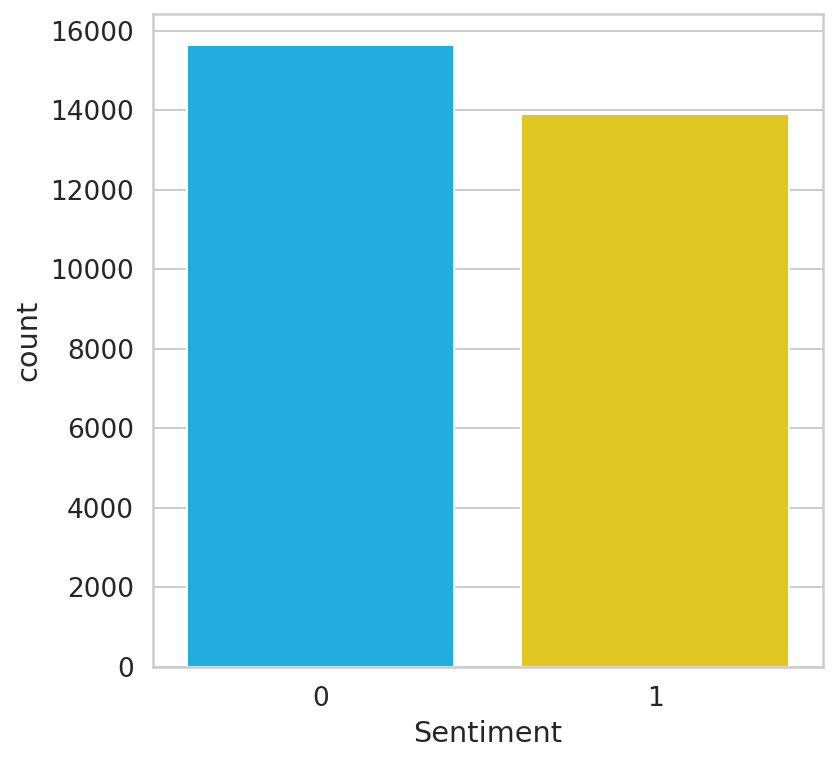

In [11]:
sns.countplot(train.sent_numeric)
plt.xlabel("Sentiment")

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Sentiment')

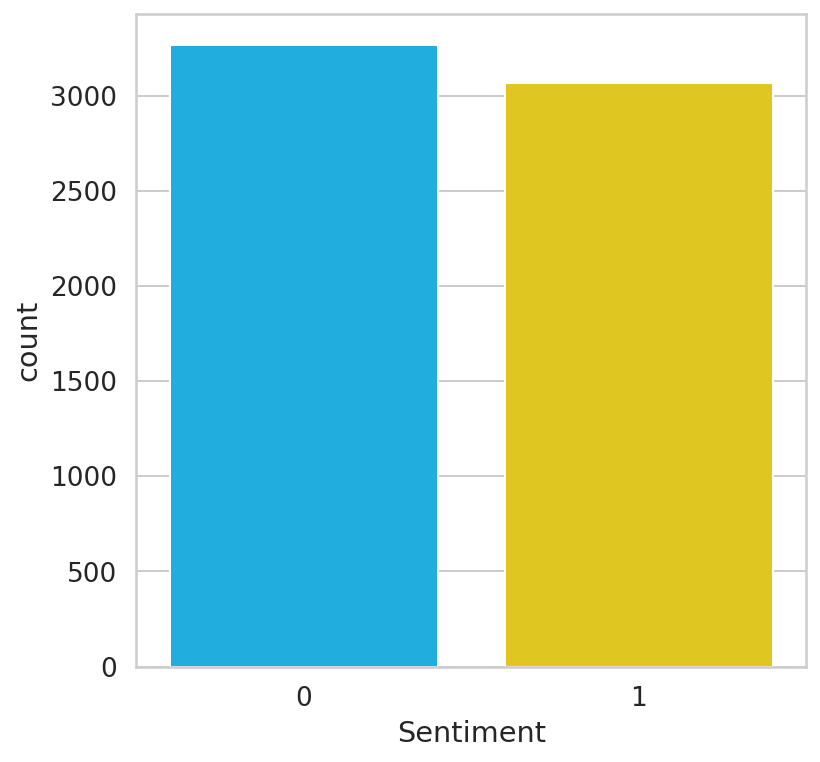

In [12]:
sns.countplot(test.sent_numeric)
plt.xlabel("Sentiment")

In [13]:
# !pip install ipywidgets
# !pip install iprogress
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
class_names = list(set(train['sent']))

In [15]:
#Choosing Sequence Length

token_lens = []

for txt in train.tweet:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


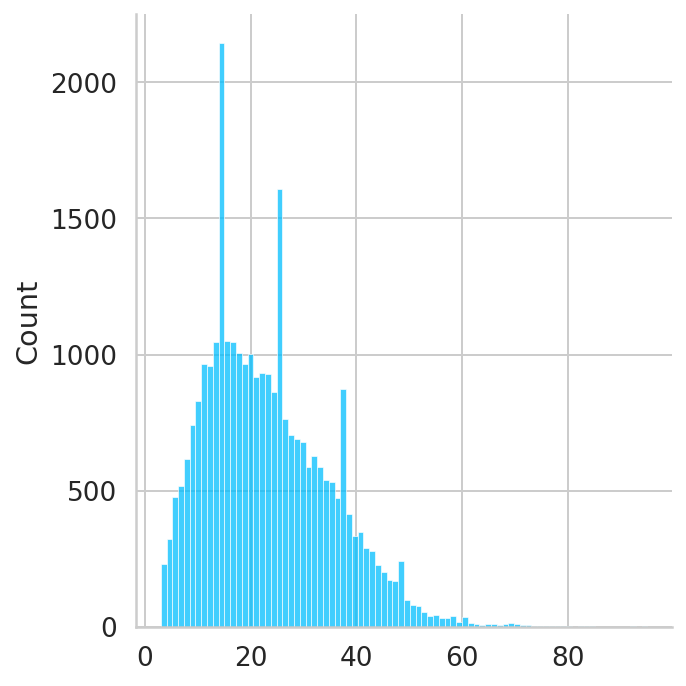

In [16]:
sns.displot(token_lens)

In [17]:
# Create a Dataset

class TwitterSentimentDataset(Dataset):
    def __init__(self, tweet, target, tokenizer, max_len):
        self.tweet = tweet
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.tweet)
    
    def __getitem__(self, item):
        tweet = str(self.tweet[item])
        
        encoding = tokenizer(
            tweet,
            max_length=self.max_len,
#             pad_to_multiple_of=True,
            padding='max_length',
            truncation='only_first',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        
        return {
            'tweet': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(self.target[item], dtype=torch.long)
        }
    

In [30]:
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3

In [31]:
df_val, df_test = train_test_split(test, test_size=0.5, random_state=RANDOM_SEED)

In [32]:
df_val.shape

(3165, 7)

In [33]:
df_test.shape

(3166, 7)

In [34]:
train.shape

(29543, 7)

In [35]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TwitterSentimentDataset(
        tweet = df.tweet.to_numpy(),
        target=df.sent_numeric.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0)

In [36]:
train_data_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [37]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet', 'input_ids', 'attention_mask', 'targets'])

In [38]:
print(data['input_ids'].shape)

torch.Size([16, 128])


In [39]:
print(data['attention_mask'].shape)

torch.Size([16, 128])


In [40]:
print(data['targets'].shape)

torch.Size([16])


In [41]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        # self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_ids, attention_mask):
        returned = self.bert(
        input_ids = input_ids,
        attention_mask=attention_mask
        # return_dict=False # https://stackoverflow.com/questions/65082243/dropout-argument-input-position-1-must-be-tensor-not-str-when-using-bert
        )
        pooled_output = returned["pooler_output"]
        output = self.drop(pooled_output)
        # output = self.out(output)
        return self.out(output) #self.softmax(output)

In [43]:
model = SentimentClassifier(len(class_names))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
model = model.to(device)

In [45]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 128])
torch.Size([16, 128])


In [46]:
model(input_ids, attention_mask)
# F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[ 0.7134,  0.5801],
        [ 0.6244,  0.2006],
        [ 0.5352,  0.2775],
        [ 0.6123,  0.0440],
        [ 0.7378,  0.3604],
        [ 0.3222,  0.1954],
        [ 0.5130,  0.5693],
        [ 0.4263,  0.7640],
        [ 0.5108,  0.2112],
        [ 0.4459,  0.3870],
        [ 1.0005, -0.1059],
        [ 0.7286,  0.6569],
        [ 0.2532, -0.3147],
        [ 0.5314,  0.1409],
        [ 0.6270,  0.0341],
        [ 1.0287,  0.8695]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [47]:
type(data)

dict

In [48]:
data['input_ids'].shape

torch.Size([16, 128])

In [50]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [51]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
    ):

    model = model.train()

    losses = []
    correct_predictions = 0

    count = 0
#     bar = progressbar.ProgressBar(maxval=train.shape[0], widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
#     bar.start()
    for d in data_loader:
        count += 1
#         bar.update(count)
#         sleep(0.1)
        if(count % 100 == 0): print(count, end=" ")
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double()/n_examples, np.mean(losses)
    
    

In [52]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(
                input_ids = input_ids,
                attention_mask = attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double()/n_examples, np.mean(losses)


In [53]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train)
    )
    
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
    )
    
    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'model.bin')
        best_accuracy = val_acc

Epoch 1/3
----------
100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 Train loss 0.5627645272933023 accuracy 0.7124868835257083
Val loss 0.5158223008567636 accuracy 0.7481832543443917

Epoch 2/3
----------
100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 Train loss 0.42167097803671166 accuracy 0.8079071184375317
Val loss 0.5378478757961832 accuracy 0.7462875197472353

Epoch 3/3
----------
100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 Train loss 0.30851767844816497 accuracy 0.8760789357885117
Val loss 0.6834225948862355 accuracy 0.7371248025276461

CPU times: user 43min 42s, sys: 29min 41s, total: 1h 13min 23s
Wall time: 1h 13min 28s


In [54]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.7334175615919141

In [55]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('model.bin'))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [56]:
def get_predictions(model, data_loader):
    model = model.eval()
    tweet_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            texts = d['tweet']
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
            
            outputs = model(
                input_ids = input_ids,
                attention_mask = attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            
            tweet_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return tweet_texts, predictions, prediction_probs, real_values

In [57]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [58]:
test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

In [59]:
test_acc

tensor(0.7378, device='cuda:0', dtype=torch.float64)

In [60]:
print(classification_report(y_test, y_pred, target_names = class_names))

              precision    recall  f1-score   support

     Neutral       0.71      0.82      0.76      1588
 Non_neutral       0.78      0.66      0.71      1578

    accuracy                           0.74      3166
   macro avg       0.74      0.74      0.74      3166
weighted avg       0.74      0.74      0.74      3166



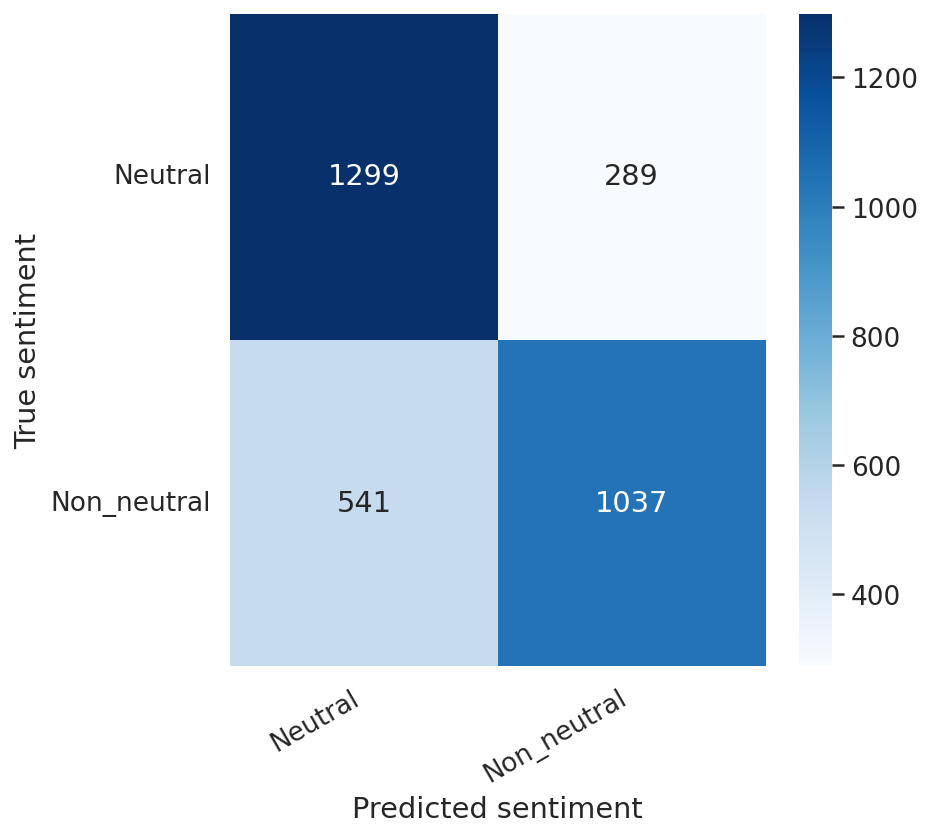

In [61]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')
    
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [63]:
print(f1_score(y_test,y_pred))

0.7141873278236915
